#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1 ]) # [Nm2] p. 4721 in [3]  

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.76629245, -0.25387542,  0.59020603],
       [ 0.36514452,  0.92792983, -0.07493808],
       [-0.52864484,  0.27293498,  0.80376684]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002420


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000225


In [37]:
C1(dx,dy,dz,Ret)

array([[ 3.07440081e-02,  3.00209512e+00, -1.50905524e-02,
        -6.23595364e-01,  1.10237910e+00, -3.73251283e+00,
         1.12647478e+00,  2.13935695e-01,  1.10728145e-02,
        -4.88999286e-02, -1.33887456e-01, -8.54036775e-03,
         2.22002433e+00,  3.56647991e-02,  4.54265712e-01,
        -8.08560228e-01,  1.43217903e-02, -5.52864514e-01,
        -5.16779032e-01, -1.87159048e+00,  1.37703736e-02,
        -4.81849174e-02, -9.31680261e-01, -6.03088244e-01,
        -3.92936324e+00,  6.55367143e-01, -7.23002592e-02,
         4.33079719e-02,  6.15550568e-03, -5.80387292e-01,
        -1.08366564e-01, -8.86546121e-01,  3.29783923e+00,
        -4.44871576e-01, -2.50192025e+00, -1.71902260e-03,
        -1.30090327e-02, -1.62181518e-02, -4.91206462e+00,
         2.90815177e-02, -4.76281042e-02,  1.59394130e-01,
         9.08590675e-02,  6.70570100e-01, -1.01849553e-01,
        -1.60129224e-01,  4.13678704e-01, -1.04585887e+00,
        -1.57202852e-02,  4.09976438e-02],
       [ 6.21

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.76440906e+02,  3.56818319e+04,  2.68402701e+04],
       [ 1.72291258e+04, -5.62543042e+03, -3.19414107e+02],
       [-8.66051926e+01, -2.19431706e+03,  1.33378004e+04],
       [-3.57883496e+03, -6.54564049e+03,  9.39788508e+03],
       [ 6.32659109e+03, -4.18966636e+03,  6.42637780e+03],
       [-2.14210178e+04,  5.20028048e+03, -4.74181756e+03],
       [ 6.46487696e+03, -6.85723079e+03,  7.30381099e+03],
       [ 1.22778422e+03, -2.88979728e+04, -1.68300444e+03],
       [ 6.35472581e+01,  3.30921555e+04, -1.12517431e+04],
       [-2.80638350e+02,  3.74612871e+02, -2.14215545e+03],
       [-7.68384654e+02,  1.48841299e+03,  4.81638950e+03],
       [-4.90134604e+01, -6.24728721e+02,  4.43451859e+03],
       [ 1.27407950e+04,  2.39940010e+04, -2.24635821e+03],
       [ 2.04681492e+02, -5.43282830e+03,  1.21040693e+03],
       [ 2.60704634e+03, -1.19027804e+02, -3.03086284e+02],
       [-4.64035459e+03, -1.60543404e+04, -1.34970145e+04],
       [ 8.21932406e+01, -4.32299144e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000361


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000217


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000028


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64), B.T.astype(np.float64))
# def phi(x, y, z, Ret,dummy,dummy1): # here check

#     B = [1e-10]
#     s = 0
#     for i in range(1, len(x)):
#         s+=np.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         B.append(s)
# #     B1=np.vstack([B, np.zeros(len(y)),np.zeros(len(z))])
#     B1=np.array(B).reshape(len(x),1)
#     return np.einsum('ijk,ip->ijp', Ret, B1).squeeze()

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.81364886, -1.85722345, -0.66919164],
       [-1.99673484,  0.86780379, -1.12755443],
       [ 0.06771101, -1.12975455,  1.50136926],
       [-2.24323087, -0.81251857, -1.27310537],
       [-1.32799582,  1.11290817,  1.14815463],
       [-1.12139261,  0.88996355, -1.18484719],
       [-0.05880706, -1.7692963 , -0.22272821],
       [ 0.1758947 ,  0.42341013,  0.08861258],
       [-1.27234445, -2.12994714, -1.35805061],
       [ 1.30436016,  0.13269647,  0.59122479],
       [-0.09284046,  1.39152159, -0.63187213],
       [ 1.53847056,  0.74595779,  0.14721938],
       [ 0.56002888,  0.53648445, -1.59947294],
       [-0.70840656,  0.54209286,  1.12973345],
       [ 0.86039606,  0.11916238,  2.16971036],
       [-0.62263599, -0.79118575, -1.62700751],
       [ 1.06896206, -0.48447696, -0.65804899],
       [-0.3725946 , -1.12287553,  1.10283049],
       [-1.45578594,  1.53773333, -0.01474594],
       [-1.21589661, -0.6566224 , -0.32929418],
       [ 0.81075568, -1.28967951, -0.294

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000166


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000614


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000627


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.86829518,  0.47407669,  0.78613241],
       [ 0.28172411,  0.60528333,  0.25693233],
       [-1.41563949, -0.78291692,  0.13599557],
       [ 0.19507111, -1.81247148, -0.20477491],
       [-0.08090787,  0.34114668, -0.60203814],
       [-0.84862293,  2.81585205, -0.98858435],
       [ 0.37849822,  2.21971464,  1.22220073],
       [ 0.21454349,  1.82544818, -1.14825881],
       [ 1.50689343,  0.75241807,  0.5016775 ],
       [-0.46361521,  0.09532399,  0.55122926],
       [ 0.251541  , -0.9359597 , -0.02852135],
       [-0.4456385 , -1.67186421,  1.09781875],
       [-1.09086924,  0.12799975,  0.50722424],
       [ 2.01905191,  1.25485869, -1.22007266],
       [ 1.32908256,  0.50919635,  0.70768687],
       [ 0.94994796, -0.13974128,  0.21397475],
       [-0.81010975,  0.56357039,  0.51592089],
       [ 0.44789479,  1.94703577,  1.60892876],
       [ 0.47583908, -1.97781858, -0.74853285],
       [ 2.38698666,  1.18133638,  0.2194333 ],
       [-1.00477491,  0.5285895 ,  0.411

In [63]:
def d_s(f,a,b,c,Ret,omega,force): # here new

    fun = f(a,b,c,Ret,omega, force)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None)

array([[ 0.01059749, -0.01791633,  0.02362563, -0.00418838,  0.00037526,
        -0.01863038,  0.0138295 , -0.00299167,  0.00683737,  0.00413443,
        -0.01814141, -0.00535077, -0.01919922,  0.00531799,  0.01846456,
        -0.00756501, -0.00158768,  0.01997655, -0.01389478,  0.00291229,
         0.00888722, -0.00455369,  0.01167486,  0.02804374, -0.02060572,
        -0.02529171,  0.0017168 , -0.01974236, -0.00408907, -0.01577962,
        -0.01231775, -0.02552424, -0.01262564, -0.0040029 , -0.01954377,
         0.00825355,  0.00141432,  0.01474197,  0.00516463, -0.0125447 ,
         0.0173688 ,  0.00392905, -0.0045254 , -0.01451678,  0.00430803,
         0.00078904,  0.01011292,  0.02191088,  0.00236932, -0.01074974],
       [ 0.0597006 ,  0.0949921 , -0.14967282,  0.10735491, -0.12680894,
         0.10856071,  0.02176757, -0.00729545,  0.12454647, -0.0475049 ,
         0.06241604, -0.00096721,  0.16511045, -0.11942003, -0.2094759 ,
         0.15728218,  0.07543382, -0.11372182, -0.

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None), None)
print(datetime.now() - startTime1)

0:00:00.001137


In [67]:
def ne(x,y,z,Ret,omega,force): # here new

#     A=np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',Ret, CT), np.transpose(Ret,(0,2,1)))
#     B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', Ret,force
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([0,0,0]).reshape(3,1)).squeeze()
                    ) 

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None), None)

array([[ 1.18216927e-06, -3.12386807e-07, -5.50127347e-07,
        -2.19943478e-07, -1.55194199e-06, -2.10311182e-06,
         2.85572746e-07, -3.27797277e-07,  1.51992744e-06,
        -1.44912234e-06, -1.97347521e-06, -6.41894776e-07,
         1.21155873e-06,  1.29087815e-06,  2.72834255e-06,
        -1.57713476e-06, -4.48121868e-07, -1.90181340e-06,
        -3.16443482e-06,  3.80699036e-08,  7.81855259e-07,
        -1.44090046e-06, -5.48127048e-07,  3.00825204e-06,
         1.69427853e-07, -5.78624091e-07,  2.42961716e-06,
         1.18564154e-06, -2.70466783e-07,  2.00317967e-06,
        -6.49488825e-08, -2.60682244e-06,  3.38653054e-07,
        -2.91544014e-08,  3.41667394e-06, -1.05024857e-07,
         4.42610934e-07, -3.10599567e-07, -1.69656136e-06,
        -2.00301090e-06, -2.98217080e-07, -4.95317479e-07,
        -1.38370493e-06, -1.98228615e-06,  1.15248129e-06,
        -3.72617893e-07,  3.65898198e-07,  8.65538850e-07,
        -2.37414451e-07,  2.41424596e-07],
       [-5.00

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.76440906e+02, -1.72291258e+04,  8.66051926e+01,
         3.57883496e+03, -6.32659109e+03,  2.14210178e+04,
        -6.46487696e+03, -1.22778422e+03, -6.35472581e+01,
         2.80638350e+02,  7.68384654e+02,  4.90134604e+01,
        -1.27407950e+04, -2.04681492e+02, -2.60704634e+03,
         4.64035459e+03, -8.21932406e+01,  3.17290821e+03,
         2.96581240e+03,  1.07411213e+04, -7.90286413e+01,
         2.76534876e+02,  5.34694464e+03,  3.46114390e+03,
         2.25507490e+04, -3.76117427e+03,  4.14933641e+02,
        -2.48545920e+02, -3.53266560e+01,  3.33086237e+03,
         6.21919389e+02,  5.08791827e+03, -1.89264113e+04,
         2.55313307e+03,  1.43586052e+04,  9.86552905e+00,
         7.46592804e+01,  9.30765234e+01,  2.81905056e+04,
        -1.66899817e+02,  2.73339306e+02, -9.14768323e+02,
        -5.21443272e+02, -3.84842456e+03,  5.84518040e+02,
         9.18987052e+02, -2.37411612e+03,  6.00221956e+03,
         9.02192501e+01, -2.35286869e+02],
       [-3.56

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000684


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None),np.array([[-8.74311438e+02,  3.80140995e+00, -3.41005173e+01],
       [ 1.16415322e-09,  9.36807965e-08,  8.16035026e-08],
       [ 2.63564289e-07, -8.80238531e-08, -4.89089871e-08],
       [-3.46451998e-07,  4.06626768e-08, -1.13650458e-07],
       [ 3.70666385e-07,  2.06493496e-07, -1.42026693e-07],
       [ 2.38418579e-07, -3.93501978e-07,  1.93598680e-07],
       [-6.25848770e-07, -3.66308086e-08,  2.69850716e-07],
       [ 3.65078449e-07, -6.00563037e-08,  3.26079316e-07],
       [-4.02331352e-07,  2.41558155e-07, -5.63450158e-08],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08],
       [ 8.74311438e+02, -3.80140984e+00,  3.41005164e+01],
       [-8.74311438e+02,  3.80140995e+00, -3.41005173e+01],
       [ 1.16415322e-09,  9.36807965e-08,  8.16035026e-08],
       [ 2.63564289e-07, -8.80238531e-08, -4.89089871e-08],
       [-3.46451998e-07,  4.06626768e-08, -1.13650458e-07],
       [ 3.70666385e-07,  2.06493496e-07, -1.42026693e-07],
       [ 2.38418579e-07, -3.93501978e-07,  1.93598680e-07],
       [-6.25848770e-07, -3.66308086e-08,  2.69850716e-07],
       [ 3.65078449e-07, -6.00563037e-08,  3.26079316e-07],
       [-4.02331352e-07,  2.41558155e-07, -5.63450158e-08],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08],
       [ 8.74311438e+02, -3.80140984e+00,  3.41005164e+01],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08]])).T

array([[ 2.48862761e-04, -3.77393533e+00,  1.26023435e+00],
       [ 9.21548548e-15, -9.05410305e-10,  8.12365774e-10],
       [-1.52082283e-13, -7.00877239e-10,  2.23717503e-09],
       [-3.61942144e-13,  3.02116871e-09,  6.34844094e-10],
       [-2.29066696e-13,  2.58319393e-09, -2.69402966e-10],
       [ 6.78093922e-13, -3.83239359e-09, -3.01719171e-09],
       [ 2.89561137e-13, -4.55364343e-09,  1.62886649e-09],
       [ 2.58961989e-13,  1.91869763e-09, -4.53470464e-09],
       [ 3.99927740e-13, -4.52197402e-09,  4.82324997e-10],
       [ 5.23840695e-13, -4.11201586e-09, -1.17936317e-09],
       [ 4.62954988e-13, -2.53917133e-09, -2.13724919e-09],
       [ 2.10282571e-14, -8.35537137e-10,  6.23162112e-10],
       [-1.06953899e-13, -2.13599478e-10,  1.29400728e-09],
       [ 2.07956379e-14, -6.20823119e-10,  4.10787021e-10],
       [ 7.44375770e-14, -1.18859330e-09,  4.36720844e-10],
       [ 3.23977385e-14, -1.83712378e-10, -1.43544725e-10],
       [ 1.15715162e-13, -6.06172360e-10

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),np.array([[-8.74311438e+02,  3.80140995e+00, -3.41005173e+01],
       [ 1.16415322e-09,  9.36807965e-08,  8.16035026e-08],
       [ 2.63564289e-07, -8.80238531e-08, -4.89089871e-08],
       [-3.46451998e-07,  4.06626768e-08, -1.13650458e-07],
       [ 3.70666385e-07,  2.06493496e-07, -1.42026693e-07],
       [ 2.38418579e-07, -3.93501978e-07,  1.93598680e-07],
       [-6.25848770e-07, -3.66308086e-08,  2.69850716e-07],
       [ 3.65078449e-07, -6.00563037e-08,  3.26079316e-07],
       [-4.02331352e-07,  2.41558155e-07, -5.63450158e-08],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08],
       [ 8.74311438e+02, -3.80140984e+00,  3.41005164e+01],
       [-8.74311438e+02,  3.80140995e+00, -3.41005173e+01],
       [ 1.16415322e-09,  9.36807965e-08,  8.16035026e-08],
       [ 2.63564289e-07, -8.80238531e-08, -4.89089871e-08],
       [-3.46451998e-07,  4.06626768e-08, -1.13650458e-07],
       [ 3.70666385e-07,  2.06493496e-07, -1.42026693e-07],
       [ 2.38418579e-07, -3.93501978e-07,  1.93598680e-07],
       [-6.25848770e-07, -3.66308086e-08,  2.69850716e-07],
       [ 3.65078449e-07, -6.00563037e-08,  3.26079316e-07],
       [-4.02331352e-07,  2.41558155e-07, -5.63450158e-08],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08],
       [ 8.74311438e+02, -3.80140984e+00,  3.41005164e+01],
       [-2.98023224e-07, -1.12966518e-07,  3.66009772e-07],
       [ 4.76837158e-07, -1.31109118e-07, -1.54599547e-07],
       [ 1.19209290e-07,  2.26981824e-08,  5.96046448e-08],
       [-3.27825546e-07,  3.97922122e-08,  6.23986125e-08],
       [ 1.19209290e-07,  1.69966370e-08,  6.33299351e-08],
       [-2.38418579e-07,  4.86033969e-09, -2.98023224e-08],
       [ 2.70685090e-08,  9.88671569e-09,  1.33933330e-08],
       [-1.37273555e-07,  1.42728131e-08, -2.75889942e-09],
       [-8.78570409e-08,  1.33726025e-08, -1.55341862e-08],
       [ 4.22661653e-07,  1.49815795e-08,  2.09199453e-08]]))

array([[-7.79337968e+02,  1.25946280e+02,  3.77316383e+02],
       [ 2.52717091e-08,  8.12390793e-08,  9.05435323e-08],
       [ 1.56956940e-07,  2.23733041e-07,  7.01032619e-08],
       [ 1.98250747e-07,  6.35040362e-08, -3.02097245e-07],
       [ 3.64377007e-07, -2.69042232e-08, -2.58283322e-07],
       [-1.06125033e-07, -3.01729677e-07,  3.83228853e-07],
       [ 4.81560184e-07,  1.62934324e-07,  4.55412015e-07],
       [-2.76361161e-08, -4.53473200e-07, -1.91872498e-07],
       [-1.28839128e-07,  4.82197446e-08,  4.52184647e-07],
       [-2.29259724e-07, -1.17959013e-07,  4.11178890e-07],
       [ 3.97880480e-07, -2.13685529e-07,  2.53956521e-07],
       [-8.61204382e-08,  6.23076853e-08,  8.35451882e-08],
       [-3.09443104e-07,  1.29370093e-07,  2.13293145e-08],
       [ 1.13870197e-07,  4.10899753e-08,  6.20935844e-08],
       [-2.04271881e-07,  4.36518615e-08,  1.18839109e-07],
       [ 2.15931068e-08, -1.43523347e-08,  1.83733754e-08],
       [-1.10520276e-07, -5.62805395e-08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000126


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64),None)

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001339


In [82]:
d_me_

array([[-6.53339537e-03,  6.99503193e+02, -6.33541415e+02],
       [-2.10723276e-02, -5.82457016e+01,  2.71111198e+02],
       [ 7.90205281e-03,  1.97417512e+01, -9.95654983e+01],
       [-8.64556392e-02,  1.68300168e+01,  8.56502523e+02],
       [ 2.35335349e-02, -3.08160498e+02,  7.04516340e+01],
       [-1.65512589e-05,  6.70115352e+02, -6.69982117e+02],
       [-6.39099172e-03,  3.54553971e+02, -2.90013206e+02],
       [ 2.01609921e-03, -3.08144983e+00, -1.72840611e+01],
       [ 1.96673740e-05,  5.27116277e+02, -5.27341659e+02],
       [ 2.99967909e-02, -1.79940625e+02, -1.23063449e+02],
       [-6.03008391e-02,  1.32915819e+01,  5.95837894e+02],
       [ 1.54256640e-02, -1.56960570e+02,  1.14586623e+00],
       [-1.11024461e-03,  8.49063149e+02, -8.37891017e+02],
       [-3.85570913e-02,  8.58760966e+01,  3.03604791e+02],
       [ 2.12866879e-04,  7.47800201e+02, -7.49988375e+02],
       [-6.95488227e-04,  6.10820888e+02, -6.03826354e+02],
       [ 1.96283696e-02,  7.94507807e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.76440906e+02, -1.72291258e+04,  8.66051926e+01,
         3.57883496e+03, -6.32659109e+03,  2.14210178e+04,
        -6.46487696e+03, -1.22778422e+03, -6.35472581e+01,
         2.80638350e+02,  7.68384654e+02,  4.90134604e+01,
        -1.27407950e+04, -2.04681492e+02, -2.60704634e+03,
         4.64035459e+03, -8.21932406e+01,  3.17290821e+03,
         2.96581240e+03,  1.07411213e+04, -7.90286413e+01,
         2.76534876e+02,  5.34694464e+03,  3.46114390e+03,
         2.25507490e+04, -3.76117427e+03,  4.14933641e+02,
        -2.48545920e+02, -3.53266560e+01,  3.33086237e+03,
         6.21919389e+02,  5.08791827e+03, -1.89264113e+04,
         2.55313307e+03,  1.43586052e+04,  9.86552905e+00,
         7.46592804e+01,  9.30765234e+01,  2.81905056e+04,
        -1.66899817e+02,  2.73339306e+02, -9.14768323e+02,
        -5.21443272e+02, -3.84842456e+03,  5.84518040e+02,
         9.18987052e+02, -2.37411612e+03,  6.00221956e+03,
         9.02192501e+01, -2.35286869e+02],
       [-3.56

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=100

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

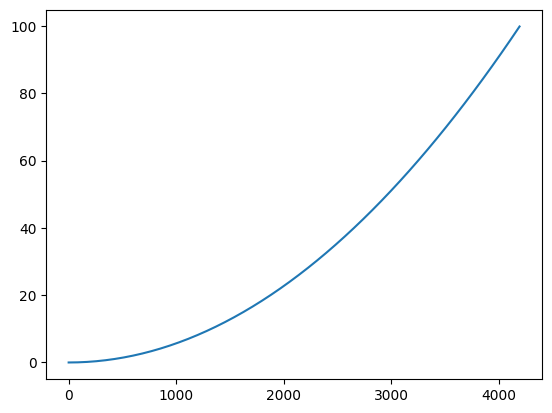

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0.000001,0.000001,0,0,0])

    Z0= -np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None),  Z0).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 8.55967198e+01, 1.71193440e+02, 2.56790159e+02,
       3.42386879e+02, 4.27983599e+02, 5.13580319e+02, 5.99177038e+02,
       6.84773758e+02, 7.70370478e+02, 8.55967198e+02, 9.41563917e+02,
       1.02716064e+03, 1.11275736e+03, 1.19835408e+03, 1.28395080e+03,
       1.36954752e+03, 1.45514424e+03, 1.54074096e+03, 1.62633768e+03,
       1.71193440e+03, 1.79753112e+03, 1.88312783e+03, 1.96872455e+03,
       2.05432127e+03, 2.13991799e+03, 2.22551471e+03, 2.31111143e+03,
       2.39670815e+03, 2.48230487e+03, 2.56790159e+03, 2.65349831e+03,
       2.73909503e+03, 2.82469175e+03, 2.91028847e+03, 2.99588519e+03,
       3.08148191e+03, 3.16707863e+03, 3.25267535e+03, 3.33827207e+03,
       3.42386879e+03, 3.50946551e+03, 3.59506223e+03, 3.68065895e+03,
       3.76625567e+03, 3.85185239e+03, 3.93744911e+03, 4.02304583e+03,
       4.10864255e+03, 4.19423927e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  8.560e+01 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 1211
    fjac: [[ 0.000e+00  0.000e+00 ...  8.139e-02  8.139e-02]
           [ 0.000e+00  0.000e+00 ...  6.801e-05  6.801e-05]
           ...
           [ 0.000e+00  0.000e+00 ... -3.327e-06  3.331e-06]
           [ 0.000e+00  0.000e+00 ...  1.221e-07  1.526e-07]]
       r: [ 5.647e+02  5.647e+02 ...  0.000e+00  0.000e+00]
     qtf: [ 1.028e-03 -9.925e-01 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
x0_=x0_-x0_[0]

In [106]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0_

In [107]:
q0

array([0.00000000e+00, 8.55967198e+01, 1.71193440e+02, 2.56790159e+02,
       3.42386879e+02, 4.27983599e+02, 5.13580319e+02, 5.99177038e+02,
       6.84773758e+02, 7.70370478e+02, 8.55967198e+02, 9.41563917e+02,
       1.02716064e+03, 1.11275736e+03, 1.19835408e+03, 1.28395080e+03,
       1.36954752e+03, 1.45514424e+03, 1.54074096e+03, 1.62633768e+03,
       1.71193440e+03, 1.79753112e+03, 1.88312783e+03, 1.96872455e+03,
       2.05432127e+03, 2.13991799e+03, 2.22551471e+03, 2.31111143e+03,
       2.39670815e+03, 2.48230487e+03, 2.56790159e+03, 2.65349831e+03,
       2.73909503e+03, 2.82469175e+03, 2.91028847e+03, 2.99588519e+03,
       3.08148191e+03, 3.16707863e+03, 3.25267535e+03, 3.33827207e+03,
       3.42386879e+03, 3.50946551e+03, 3.59506223e+03, 3.68065895e+03,
       3.76625567e+03, 3.85185239e+03, 3.93744911e+03, 4.02304583e+03,
       4.10864255e+03, 4.19423927e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

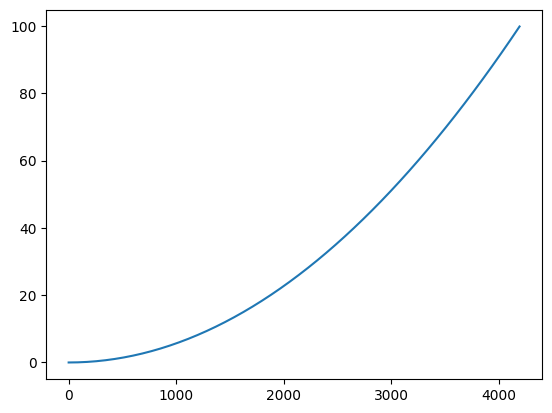

In [108]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [109]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [110]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [111]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [112]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [113]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [114]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [115]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [116]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [119]:
fors

array([[-2.26035176e+03,  2.50273471e+01, -6.40206335e+01],
       [-7.06058927e-08, -1.40811426e-06,  1.07144479e-06],
       [ 1.22468919e-07,  2.05903416e-06,  6.58397767e-07],
       [-2.20607035e-08, -4.15342631e-06, -5.88833063e-06],
       [ 2.81725079e-08, -4.24039899e-06, -4.77174558e-06],
       [-4.65661287e-08,  3.21480911e-06, -8.23818846e-06],
       [-1.63912773e-07,  7.75442459e-07,  6.31320290e-07],
       [-1.61118805e-07, -5.82158716e-07, -2.95488280e-06],
       [-2.34693289e-07, -1.87964179e-06,  1.10150722e-06],
       [ 0.00000000e+00,  1.79163180e-06, -7.16536306e-07],
       [-3.42726707e-07,  6.67915447e-06,  6.25301618e-06],
       [ 1.97440386e-07,  1.88303076e-06,  6.35633478e-06],
       [ 3.12924385e-07, -2.43680552e-06, -2.77822255e-06],
       [ 3.87430191e-07,  1.13062561e-06,  3.99188139e-06],
       [ 1.93715096e-07, -1.44646037e-06,  2.85729766e-06],
       [-2.30967999e-07,  1.25458908e-06,  5.13158739e-06],
       [-4.99188900e-07,  9.86270607e-07

### Vessle Simulation

In [120]:
sampleTime = 0.001              # sample time [seconds]
N = 100000                      # number of samples

In [121]:
N*sampleTime

100.0

In [122]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [123]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [124]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

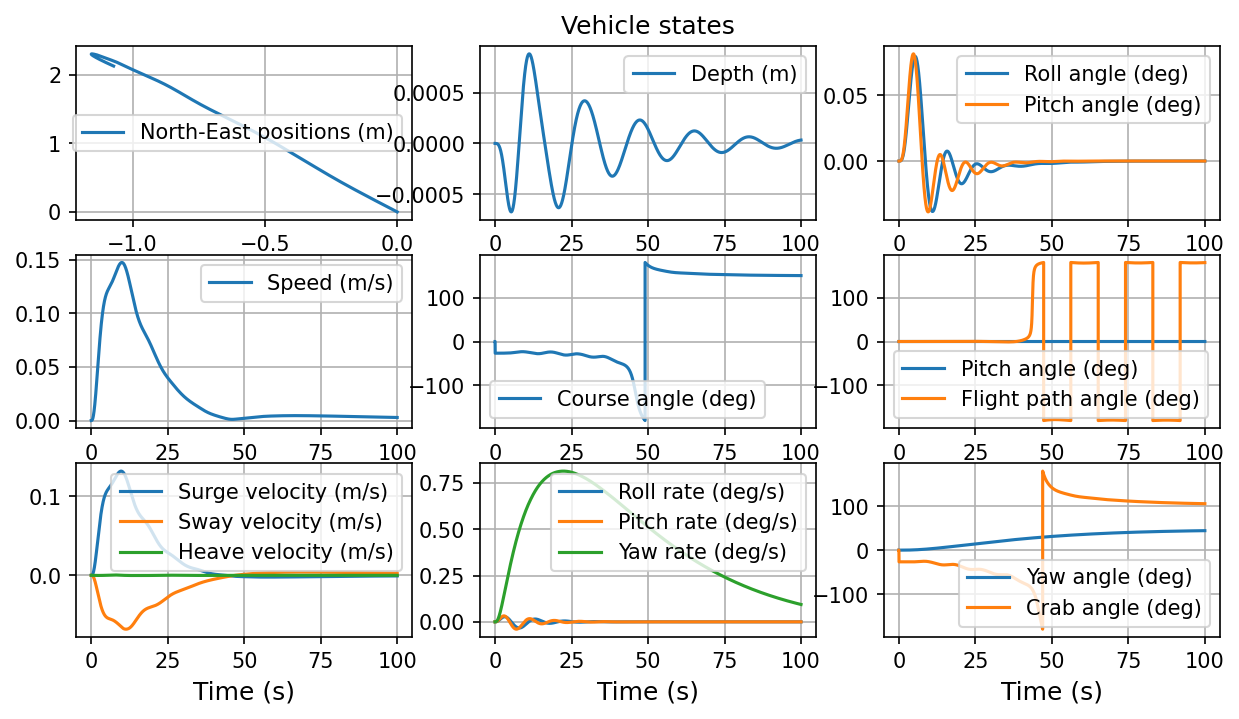

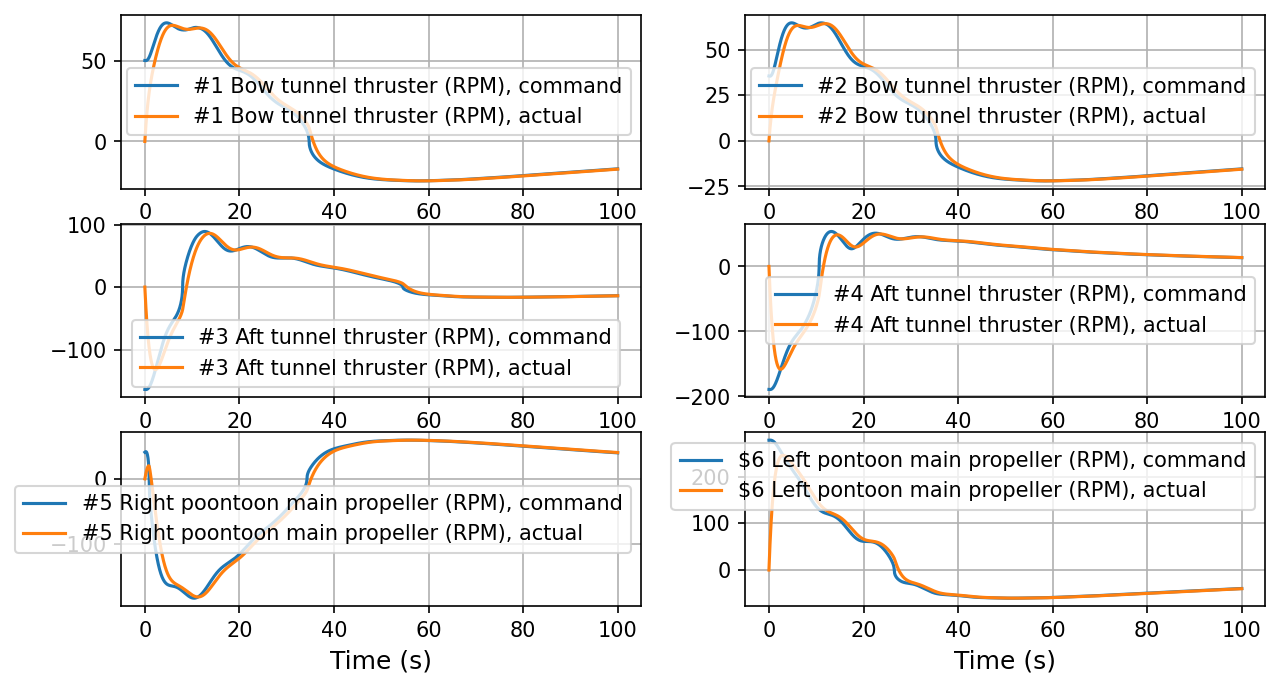

In [125]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [126]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

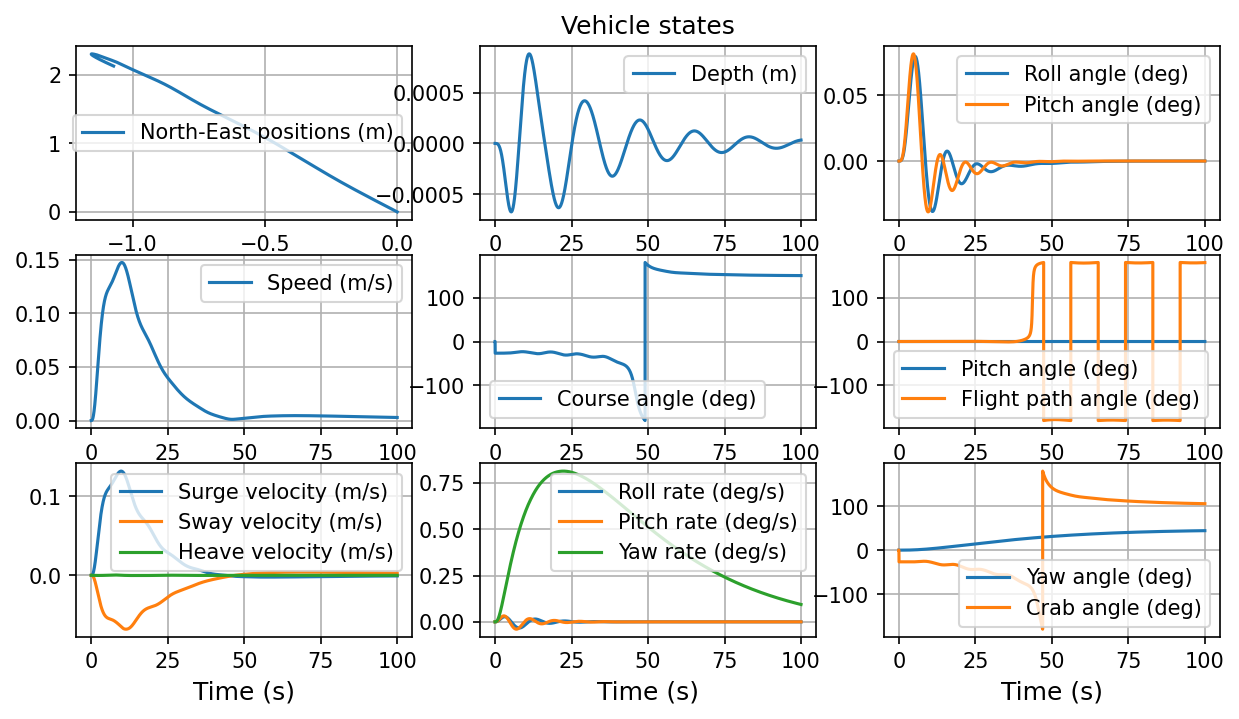

In [127]:
plotVehicleStates(simTime, simData, 3)

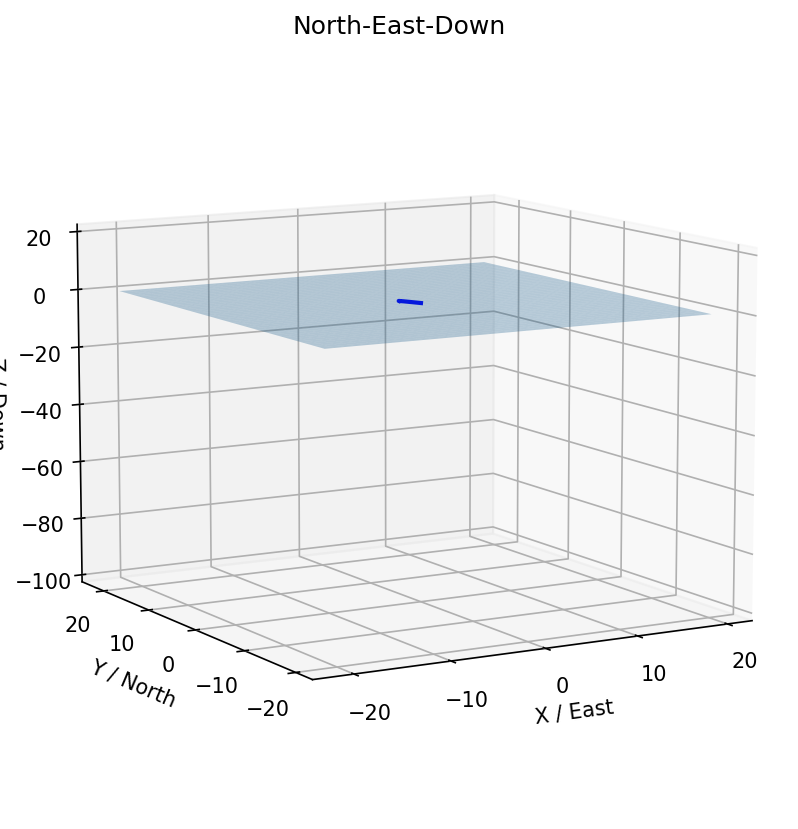

In [128]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [129]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [130]:
idx=1/0.01

In [131]:
idx

100.0

In [132]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [133]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [134]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [135]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [268]:
M_t=inert(vessel_mass*9.81*100,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [269]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [270]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
#     print(vessel_movement)
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None),fors).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), None).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),fors))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [271]:
tspan = (0., 50)
T_ = MyTime()

In [272]:
coefs = [1, 1, 1, 1, 1, 1]

In [273]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  34.39475925870104  Iteration wall clock time:  0:00:01.168007
Physical time:  1.241738183030833  Iteration wall clock time:  0:00:03.149430
Physical time:  2.4683114598244202  Iteration wall clock time:  0:00:00.352818
Physical time:  3.538409384128612  Iteration wall clock time:  0:00:01.482916
Physical time:  5.276815224888886  Iteration wall clock time:  0:00:00.718848
Physical time:  5.534356830927445  Iteration wall clock time:  0:00:00.354611
Physical time:  6.008937770685372  Iteration wall clock time:  0:00:08.175646
Physical time:  7.508616706388937  Iteration wall clock time:  0:00:01.666305
Physical time:  8.285038536498265  Iteration wall clock time:  0:00:01.516459
Physical time:  9.489544825048574  Iteration wall clock time:  0:00:00.725318
Physical time:  10.290487838050474  Iteration wall clock time:  0:00:01.423123
Physical time:  11.48881058850586  Iteration wall clock time:  0:00:00.727304
Physical time:  12.285180737855764  Iteration wall clock time:

### Results

In [274]:
fin=us

In [275]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.058e-01 ...  4.845e+01  5.000e+01]
        y: [[ 0.000e+00  4.914e-09 ...  3.395e-02  3.547e-02]
            [ 8.560e+01  8.560e+01 ...  8.560e+01  8.560e+01]
            ...
            [ 0.000e+00 -6.597e-13 ... -1.662e-12 -1.662e-12]
            [ 0.000e+00  2.278e-10 ... -5.457e-08 -1.983e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 146
     njev: 0
      nlu: 0

In [276]:
t=fin.t

In [277]:
fin=fin.y.T

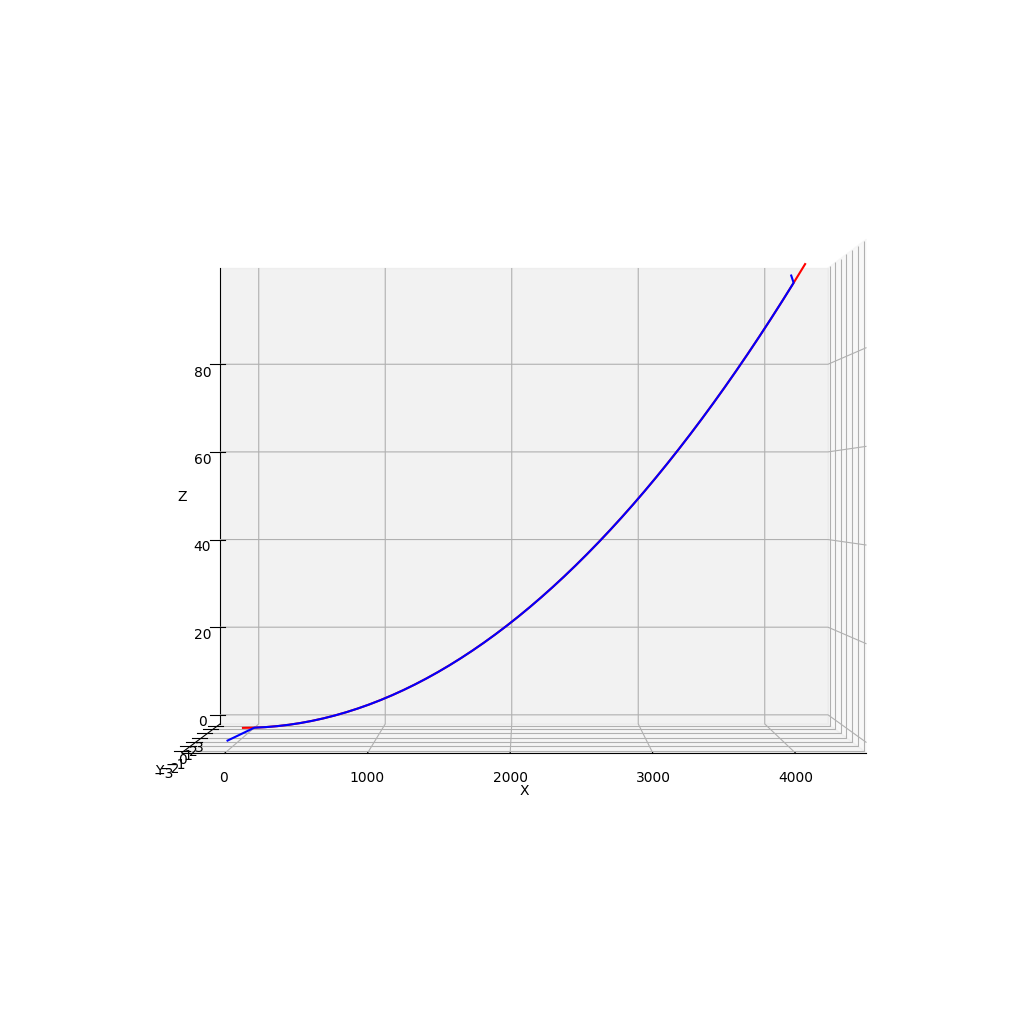

In [301]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [279]:
X,Y,Z

(array([3.54658326e-02, 8.55967198e+01, 1.71193440e+02, 2.56790159e+02,
        3.42386879e+02, 4.27983599e+02, 5.13580319e+02, 5.99177038e+02,
        6.84773758e+02, 7.70370478e+02, 8.55967198e+02, 9.41563917e+02,
        1.02716064e+03, 1.11275736e+03, 1.19835408e+03, 1.28395080e+03,
        1.36954752e+03, 1.45514424e+03, 1.54074096e+03, 1.62633768e+03,
        1.71193440e+03, 1.79753112e+03, 1.88312783e+03, 1.96872455e+03,
        2.05432127e+03, 2.13991799e+03, 2.22551471e+03, 2.31111143e+03,
        2.39670815e+03, 2.48230487e+03, 2.56790159e+03, 2.65349831e+03,
        2.73909503e+03, 2.82469175e+03, 2.91028847e+03, 2.99588519e+03,
        3.08148191e+03, 3.16707863e+03, 3.25267535e+03, 3.33827207e+03,
        3.42386879e+03, 3.50946551e+03, 3.59506223e+03, 3.68065895e+03,
        3.76625567e+03, 3.85185239e+03, 3.93744911e+03, 4.02304583e+03,
        4.10864255e+03, 4.19420380e+03]),
 array([-3.01362009e-05, -3.06166065e-11, -2.59475896e-11,  6.75823915e-12,
        -3.1632263

In [280]:
X0,Y0,Z0

(array([   0.        ,   85.59671977,  171.19343953,  256.7901593 ,
         342.38687907,  427.98359883,  513.5803186 ,  599.17703837,
         684.77375813,  770.3704779 ,  855.96719767,  941.56391743,
        1027.1606372 , 1112.75735697, 1198.35407673, 1283.9507965 ,
        1369.54751627, 1455.14423603, 1540.7409558 , 1626.33767557,
        1711.93439533, 1797.5311151 , 1883.12783487, 1968.72455463,
        2054.3212744 , 2139.91799417, 2225.51471393, 2311.1114337 ,
        2396.70815346, 2482.30487323, 2567.901593  , 2653.49831276,
        2739.09503253, 2824.6917523 , 2910.28847206, 2995.88519183,
        3081.4819116 , 3167.07863136, 3252.67535113, 3338.2720709 ,
        3423.86879066, 3509.46551043, 3595.0622302 , 3680.65894996,
        3766.25566973, 3851.8523895 , 3937.44910926, 4023.04582903,
        4108.6425488 , 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [281]:
us=fin.T

In [282]:
us.shape

(600, 23)

In [283]:
12*50

600

In [284]:
us.T[:,4*node_N+49]

array([99.88641731, 99.88641726, 99.88641379, 99.88640538, 99.88639261,
       99.88636957, 99.88633376, 99.88628549, 99.88622614, 99.88615531,
       99.88607166, 99.8859754 , 99.88586787, 99.88574808, 99.88561429,
       99.88546832, 99.88531102, 99.88513968, 99.88495491, 99.88475992,
       99.88455372, 99.88433864, 99.88423614])

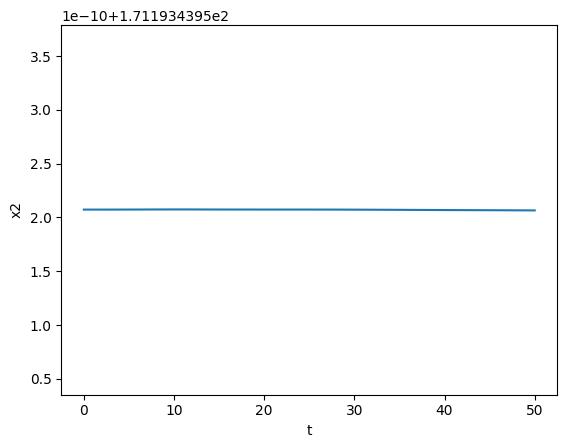

In [285]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

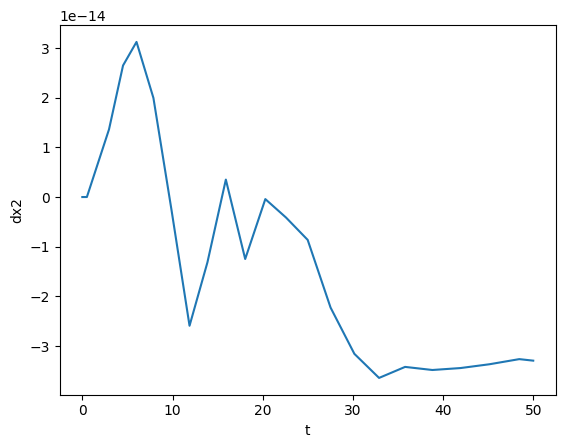

In [286]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

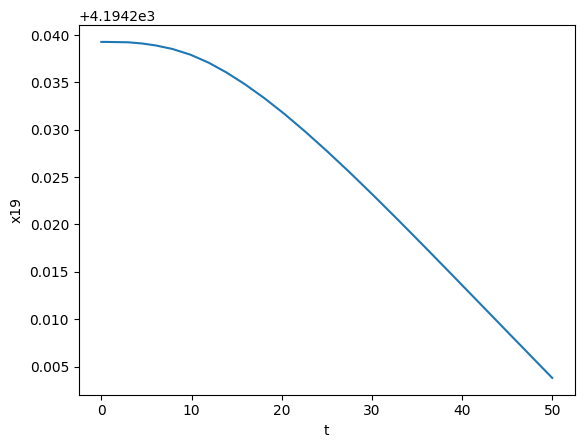

In [287]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

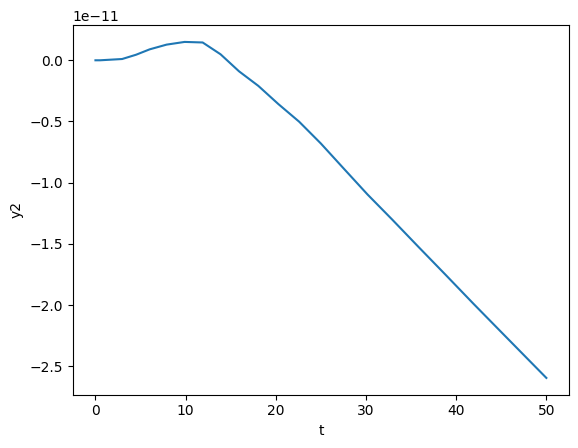

In [288]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

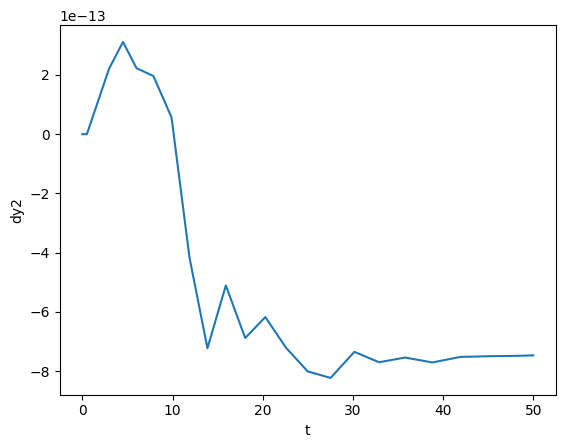

In [289]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

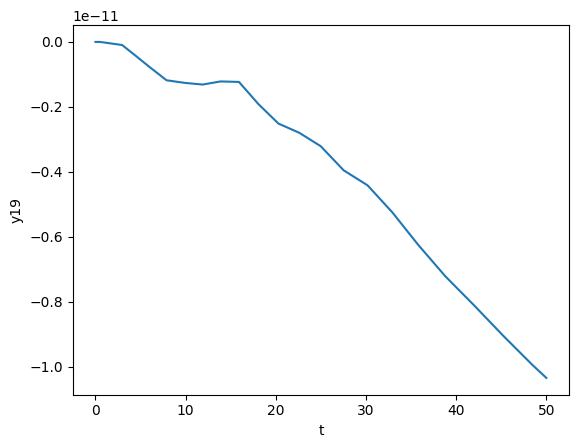

In [290]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

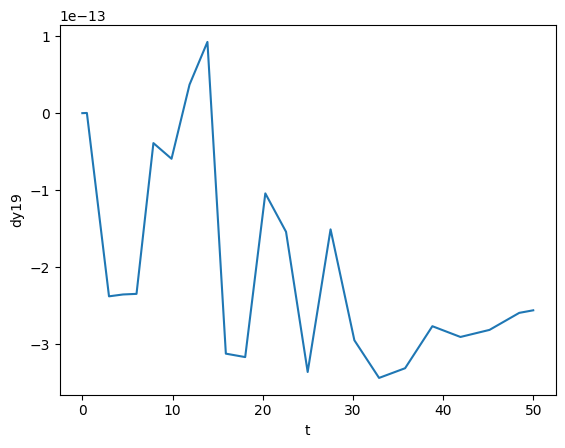

In [291]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

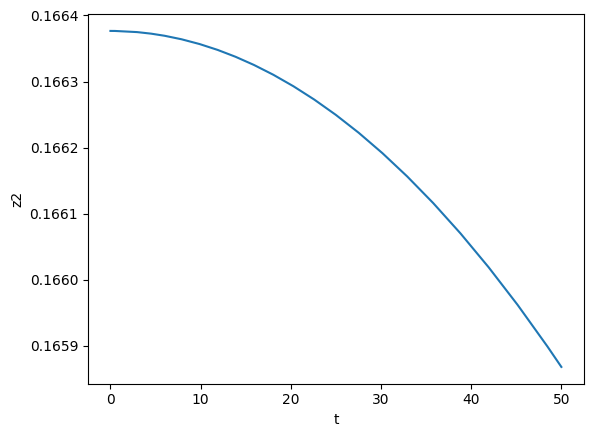

In [292]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

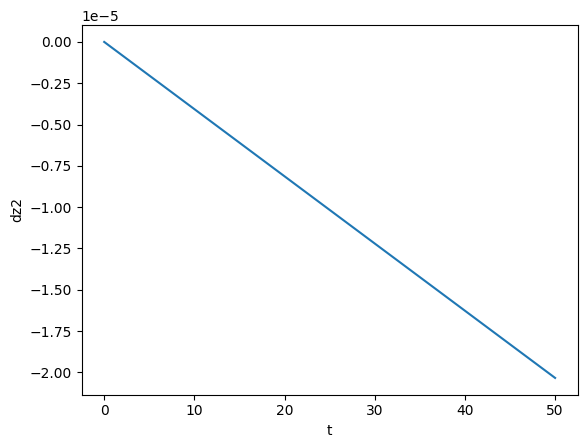

In [293]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

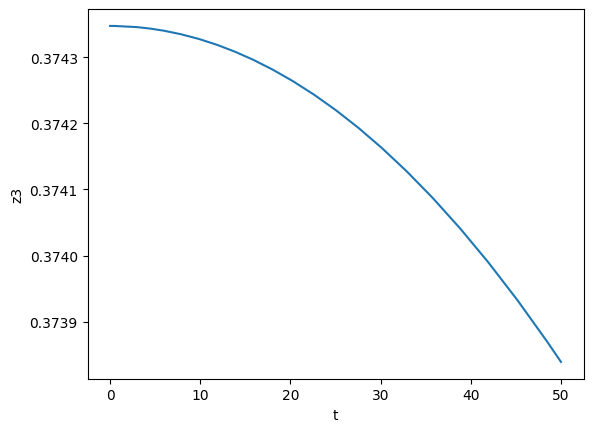

In [294]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

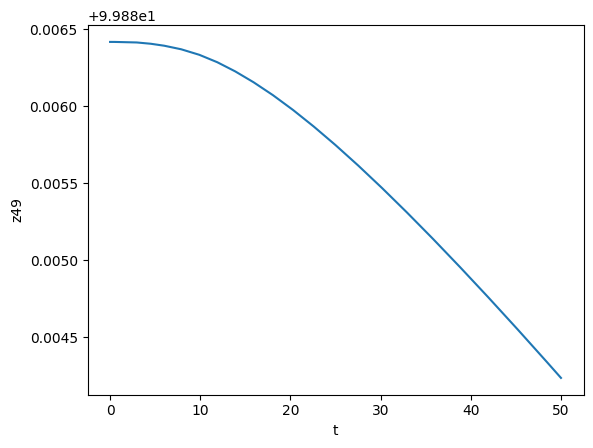

In [295]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

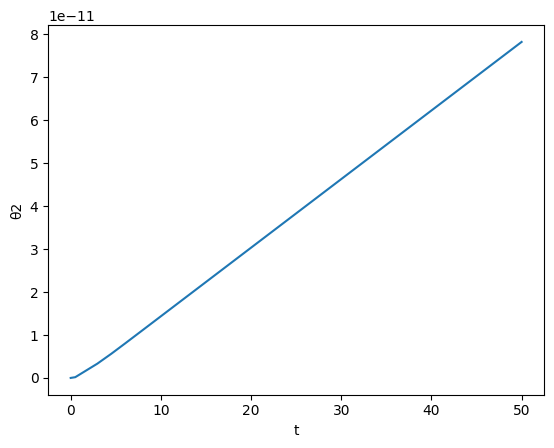

In [296]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

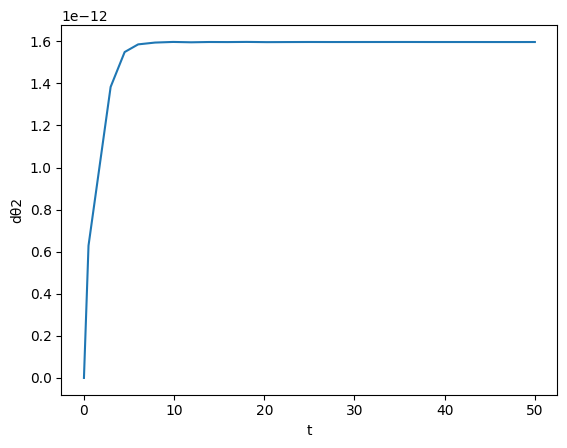

In [297]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

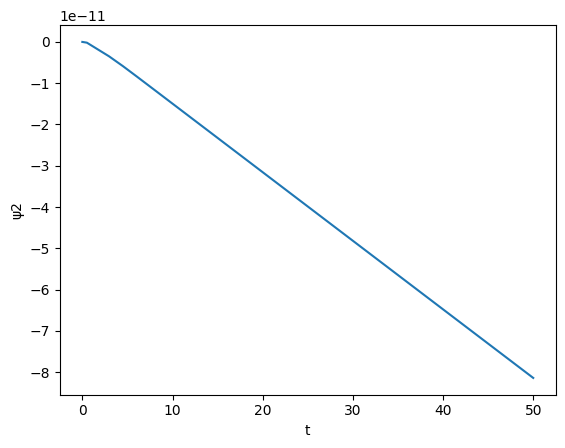

In [298]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

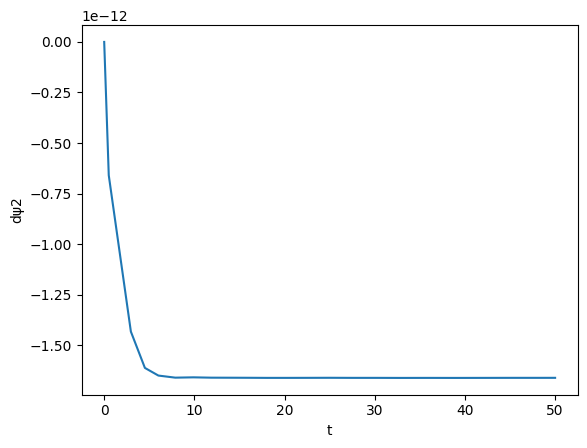

In [299]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

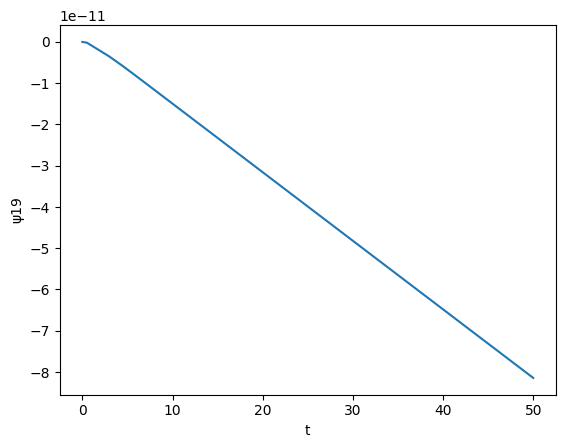

In [300]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()